# Elaborate statistics features for Silvereye

## Dependencies imports


In [1]:
import xarray as xr
import os
import sys
import pandas as pd
from functools import wraps
import numpy as np

import matplotlib.pyplot as plt

/opt/conda/envs/silvernote/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/opt/conda/envs/silvernote/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
import seaborn as sns  # noqa, pandas aware plotting library

In [ ]:
from datetime import date
from dateutil.relativedelta import relativedelta # $ pip install python-dateutil

The last section of this notebook investigates ipyleaflet for visualisation.

In [3]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, ImageOverlay

In [ ]:
import PIL

In [ ]:
from io import StringIO, BytesIO
from base64 import b64encode

In [6]:
if ('SP_SRC' in os.environ):
    root_src_dir = os.environ['SP_SRC']
elif sys.platform == 'win32':
    root_src_dir = r'C:\src\csiro\stash\silverpieces'
else:
    root_src_dir = '/silverpieces'

pkg_src_dir = root_src_dir
sys.path.append(pkg_src_dir)

In [7]:
from silverpieces import *

In [8]:
from silverpieces.functions import *

In [32]:
if ('SP_DATA' in os.environ):
    root_data_dir = os.environ['SP_DATA']
elif sys.platform == 'win32':
    root_data_dir = r'C:\data\silverpieces'
else:
    root_data_dir = '/silverpieces/notebooks/'


In [33]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# the default cmap_sequential for xarray is viridis. 'RdBu' is divergent, but works better for wetness concepts
# # https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
xr.set_options(cmap_sequential='bwr_r')

In [34]:
# Can get tassie_silo_rain.nc data from https://cloudstor.aarnet.edu.au/plus/s/nj2RevvD1EUD77n
fn = os.path.join(root_data_dir, 'tassie_silo_rain.nc')

In [35]:
tassie = xr.open_mfdataset([fn])

In [37]:
tassie

<xarray.Dataset>
Dimensions:     (lat: 79, lon: 99, time: 4383)
Coordinates:
  * lon         (lon) float64 144.1 144.1 144.2 144.2 ... 148.8 148.9 148.9
  * lat         (lat) float64 -43.95 -43.9 -43.85 -43.8 ... -40.15 -40.1 -40.05
  * time        (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2018-12-31
Data variables:
    daily_rain  (time, lat, lon) float32 dask.array<shape=(4383, 79, 99), chunksize=(4383, 79, 99)>

In [38]:
daily_rain = tassie.daily_rain

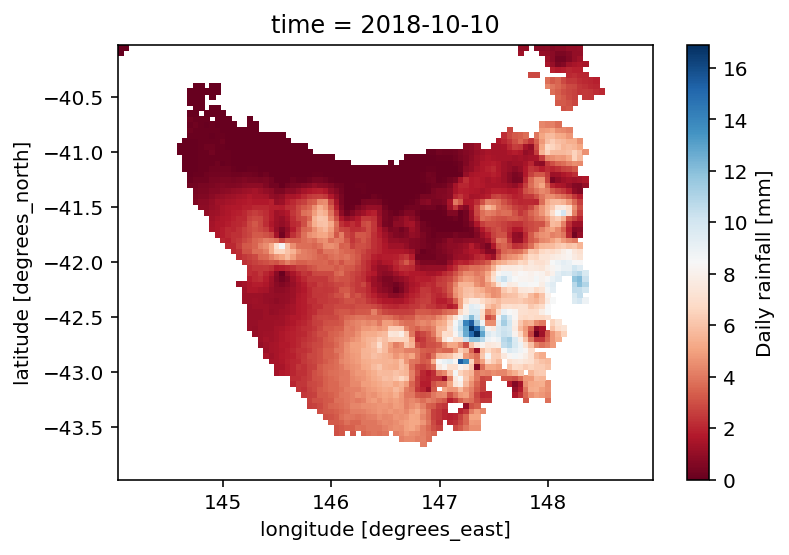

In [39]:
daily_rain.isel(time=4300).plot()

## Use case - inter-period statistical comparisons.

We want to be able to compare a grid of statistics for a period compared to all periods of similar lengths.
The start and end of the period should be as arbitrary as possible. The sliding window could however be limited or fixed to a year: it is probably moot to compare windows with shifted seasonality. 

### How does the cumulated rainfall 2016-2018 over TAS compare with all 3 year periods over the whole record?


In [40]:
s = SpatialTemporalDataArrayStat()
start_time = pd.to_datetime('2016-01-01')
end_time = pd.to_datetime('2018-12-31')

In [42]:
daily_rain.load()

<xarray.DataArray 'daily_rain' (time: 4383, lat: 79, lon: 99)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [0.7, nan, ..., nan, nan],
        [0.7, 0.6, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [1.8, nan, ..., nan, nan],
        [2.3, 1.9, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [0. , nan, ..., nan, nan],
        [0. , 0. , ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [0. , nan, ..., nan, nan],
        [0. , 0. , ..., nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 144.1 144.1 144.2 144.2 ... 148.8 148.8 148.9 148.9
  * lat      (lat) float64 -43.95 -43.9 -43.85 -43.8 ... -40.15 -40.1 -40.05
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2018-12-31
Attributes:
    long_name:    Daily rainfall
   

In [43]:
three_years_rains = s.periods_stat_yearly(daily_rain, start_time, end_time, func = np.sum)
three_years_rains.name = '3yrs cumulated rain'

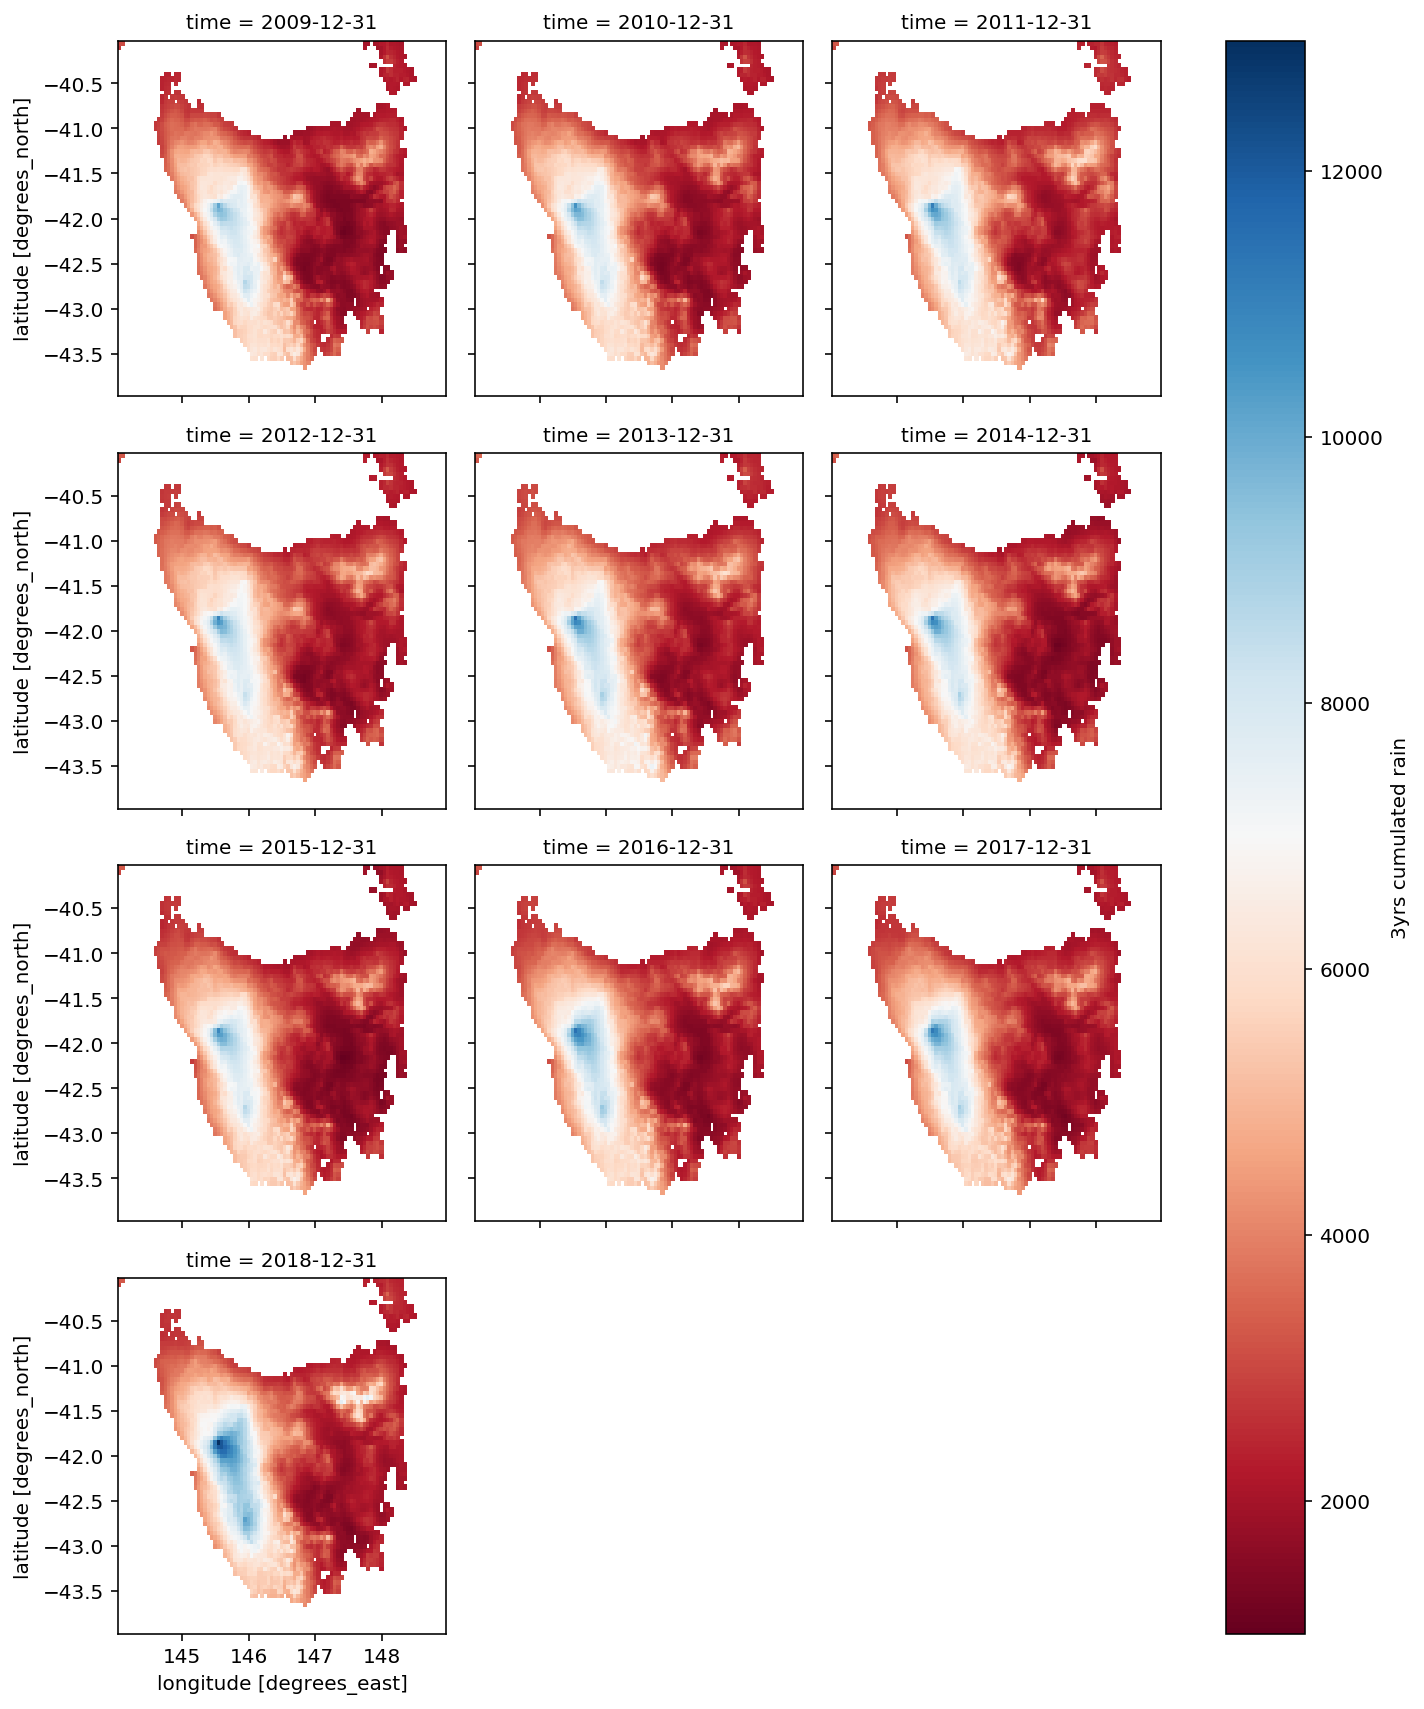

In [44]:
TIME_DIMNAME = 'time'
g_simple = three_years_rains.plot(x='lon', y='lat', col=TIME_DIMNAME, col_wrap=3)

Let's define "percentiles" of interest as boundaries to classify against 

In [47]:
q = np.array([.1, .5, .9])

In [48]:
y = s.quantile_over_time_dim(three_years_rains, q=q)

y.name = '3-yr cumulated rain quantiles'

The following color scheme may not be the best to see the map of quantile values, but should give an idea 

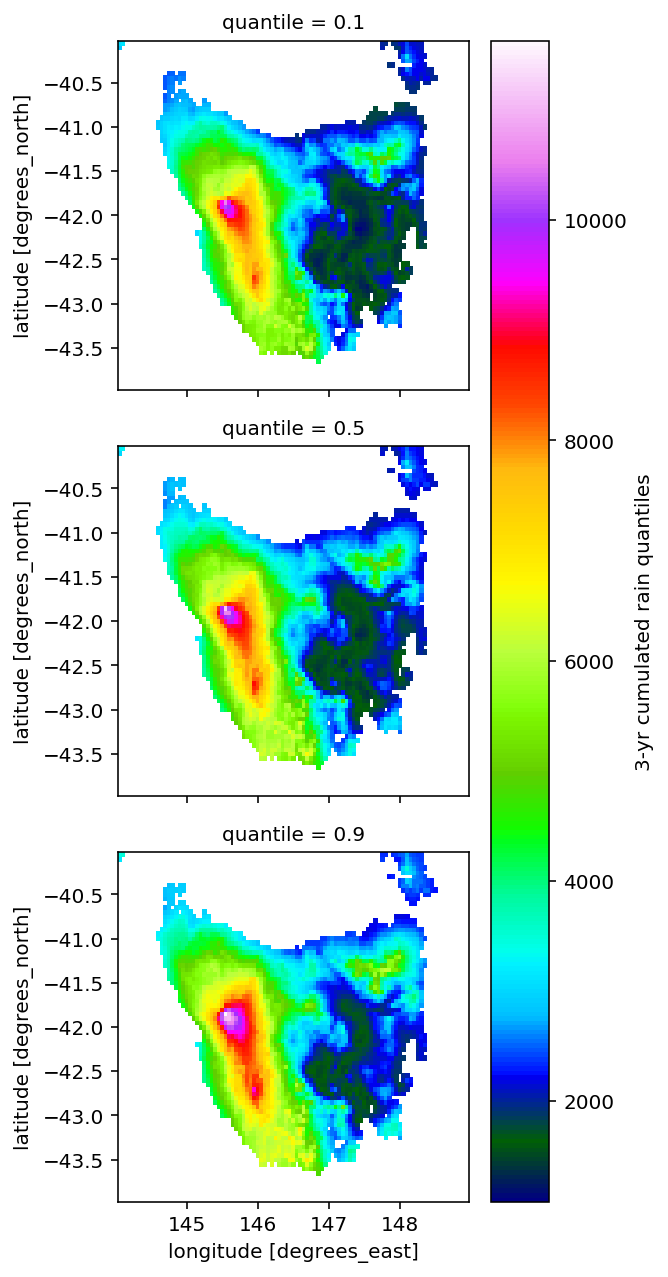

In [49]:
y.plot(x='lon', y='lat', col='quantile', col_wrap=1, cmap='gist_ncar')

So now we want a map that tells us where the last three years, for every grid cell, sits (which side of every quantile)

In [50]:
last_three_years_cumrain = three_years_rains[-1,:,:]

In [51]:
cat_q = s.searchsorted(y, last_three_years_cumrain)
cat_q.name = 'Quantile categories 10/50/90'

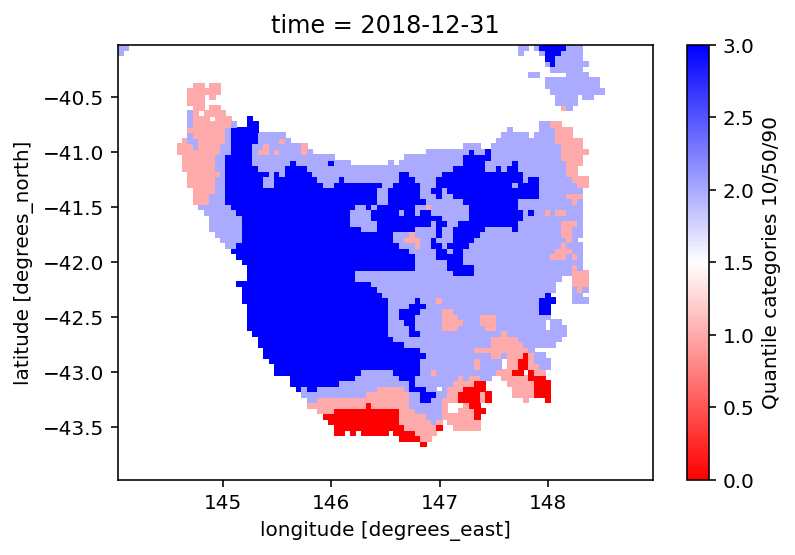

In [52]:
cat_q.plot(cmap='bwr_r')

So, the three years 2016 to 2018 have been the wettest on most of the mountainous areas of the state compared to the last decade, except for the south west National Park which has been the driest comparatively.

That said, the deviation from mean may still be quite small and it may not be a "drought" as such.

Now let's look at inter-annual variability rather than 3-year moving windows.

In [ ]:
cat_q

In [ ]:
cat_q.values.shape

In [53]:
yearly_rain = s.periods_stat_yearly(daily_rain, '2016-01-01', '2016-12-31', func = np.sum) # Yes, xarray vanilla would suffice in this case.
yearly_rain.name = 'yearly rainfall'

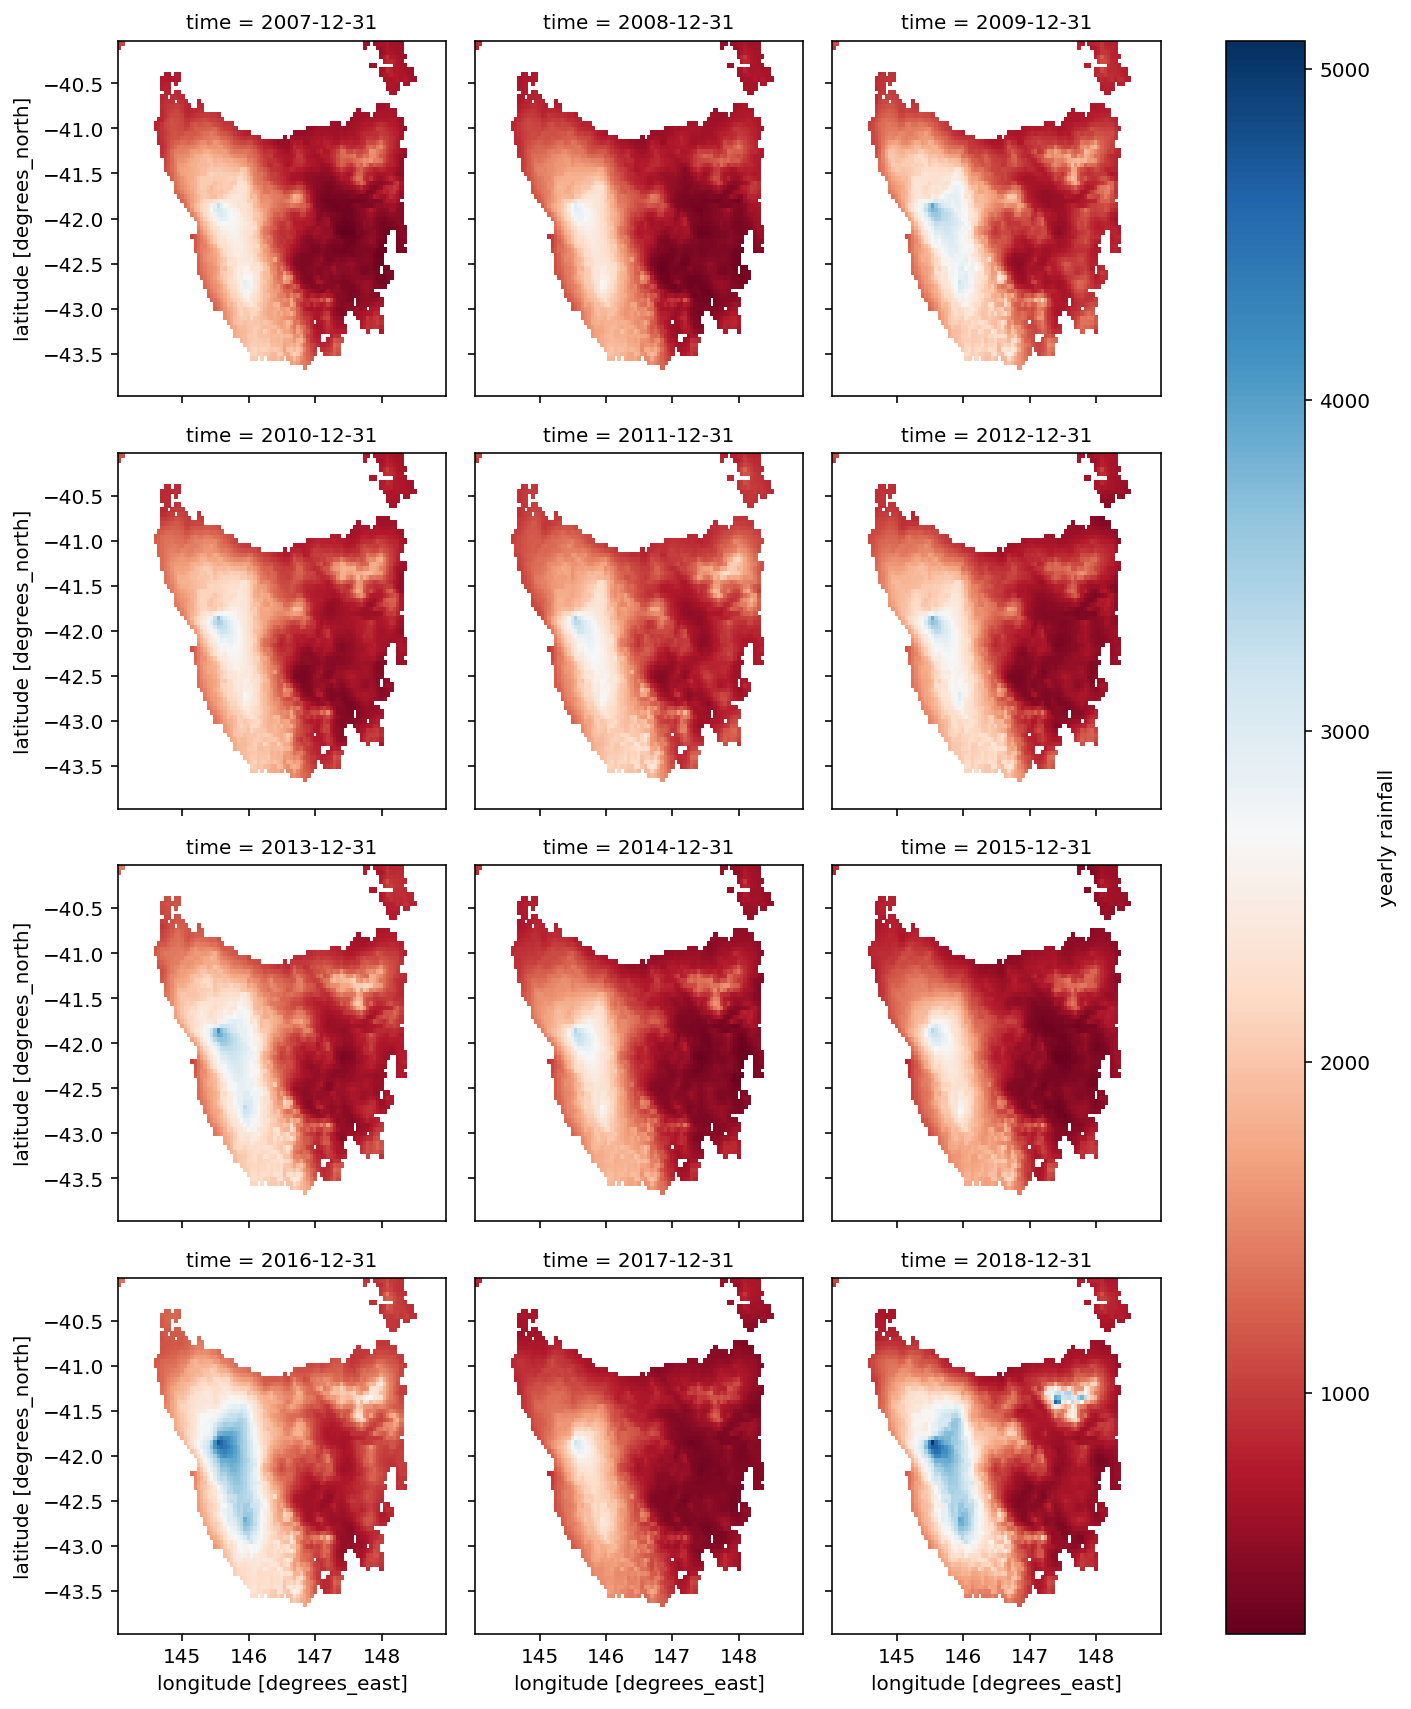

In [54]:
yearly_rain.plot(x='lon', y='lat', col=TIME_DIMNAME, col_wrap=3)

In [55]:
yearly_cat_q = yearly_rain.copy()

In [56]:
y = s.quantile_over_time_dim(yearly_rain, q=q)

In [57]:
for yr in range(len(yearly_rain.time)):
    x = yearly_rain[yr,:,:]
    cat_q = s.searchsorted(y, x)
    yearly_cat_q[yr,:,:] = cat_q

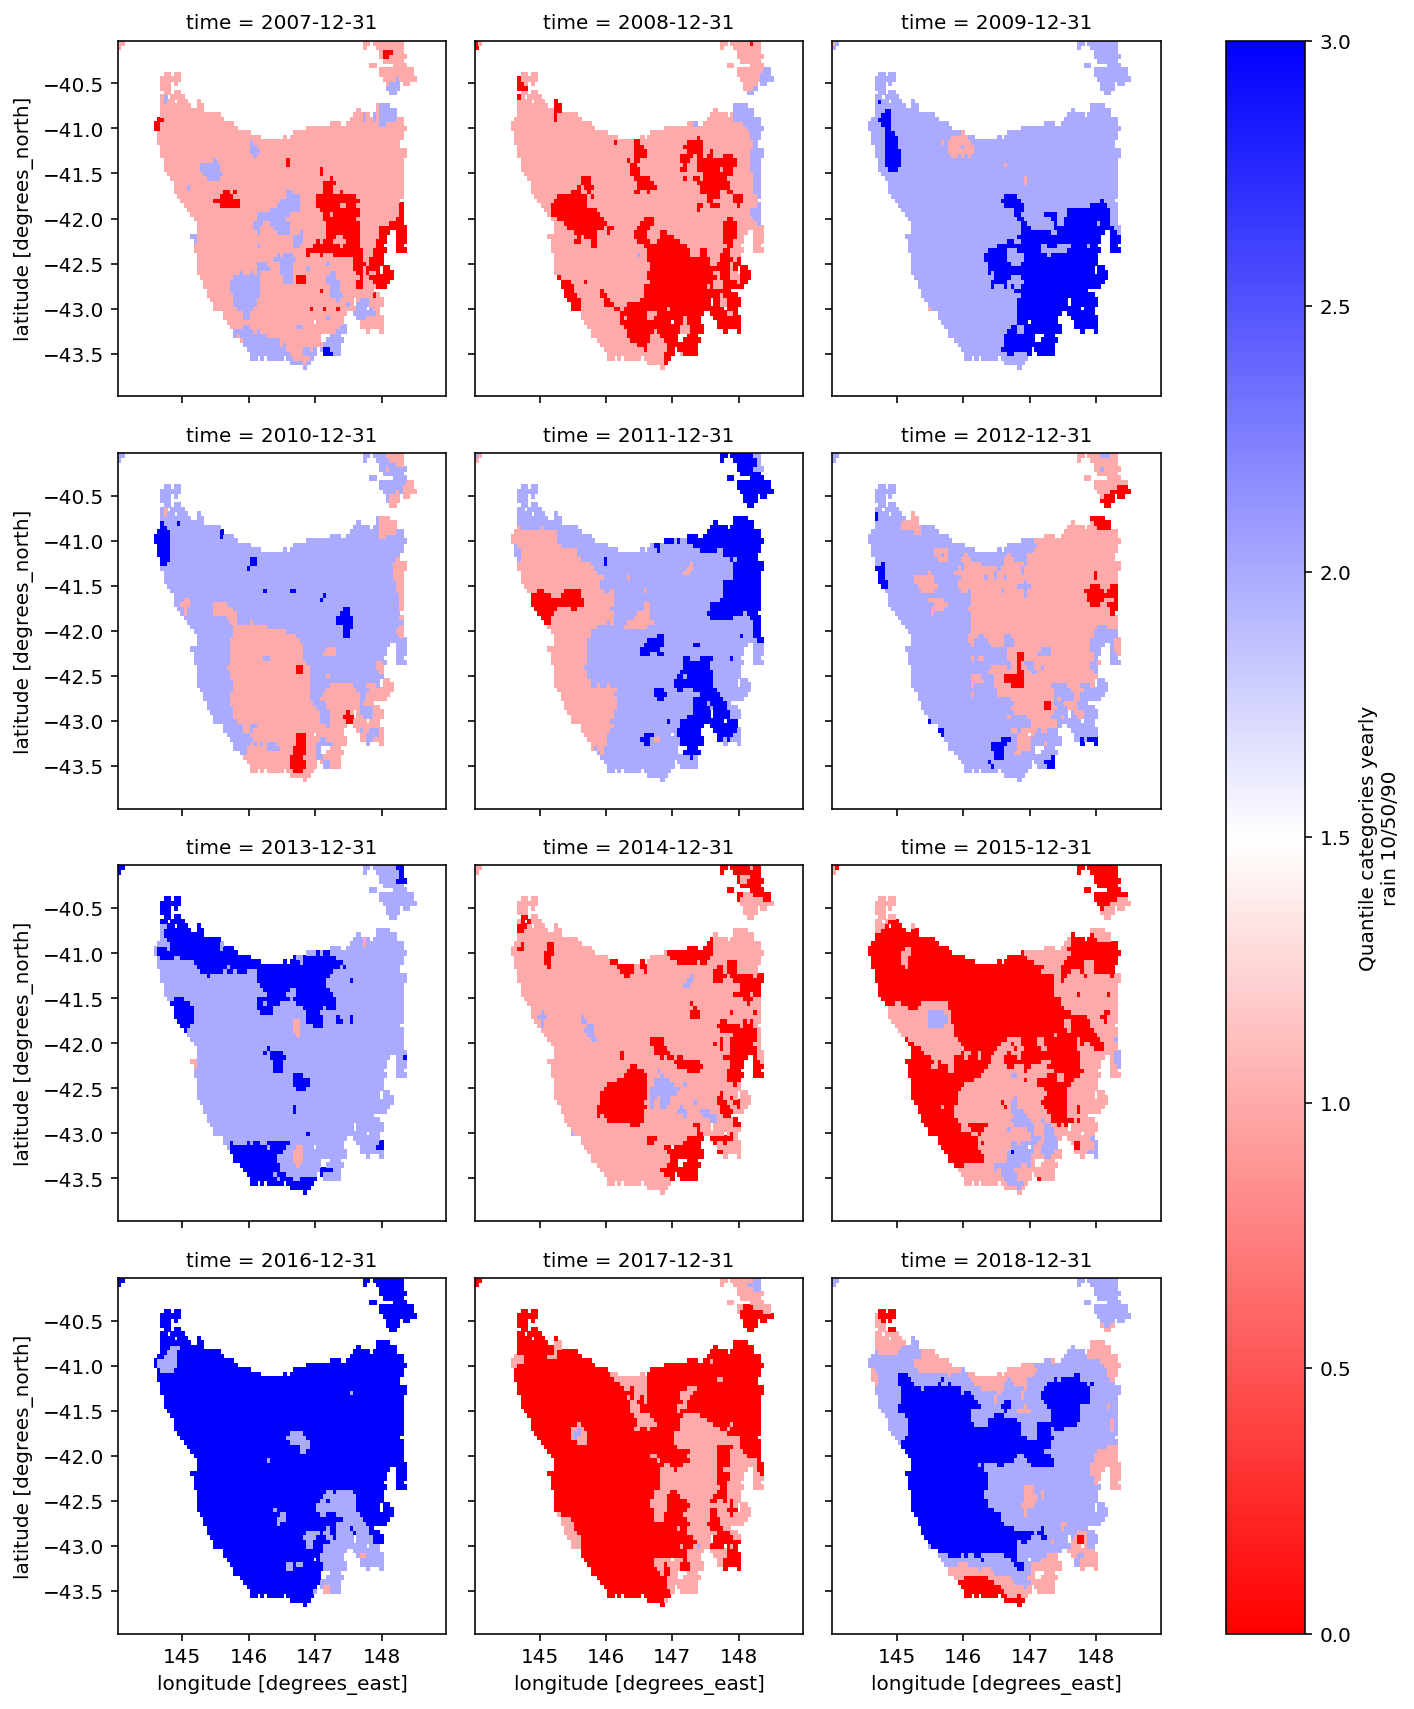

In [58]:
yearly_cat_q.name = 'Quantile categories yearly rain 10/50/90'
yearly_cat_q.plot(x='lon', y='lat', col=TIME_DIMNAME, col_wrap=3, cmap='bwr_r')

## ipyleaflet

In [ ]:
from silverpieces.vis import *

In [ ]:
bounds = make_bounds(cat_q)
imgurl = to_embedded_png(cat_q)

io = ImageOverlay(url=imgurl, bounds=bounds)

In [ ]:

center = center_from_bounds(bounds)
zoom = 7
m = Map(center=center, zoom=zoom, interpolation='nearest')
m.layout.height = '600px'

m

In [ ]:
m.add_layer(io)
io.interact(opacity=(0.0,1.0,0.01))

Try to add a colorscale legend.

In [ ]:
from branca.colormap import linear 

In [ ]:
# Could not get something that displays in the widget from matplotlib colormaps
legend = linear.RdBu_09.scale(0,3)

In [ ]:
plt.cm.bwr_r 

In [ ]:
io = ImageOverlay(url=imgurl, bounds=bounds)
io.colormap=legend

In [ ]:
from ipywidgets.widgets import Output

In [ ]:
out = Output(layout={'border': '1px solid black'})
with out:
    display(legend)

In [ ]:
from ipyleaflet import WidgetControl

In [ ]:
m = Map(center=center, zoom=zoom, interpolation='nearest')
m.layout.height = '600px'

In [ ]:
m.add_layer(io)
io.interact(opacity=(0.0,1.0,0.01))

In [ ]:
widget_control = WidgetControl(widget=out, position='topright')
m.add_control(widget_control)
display(m)